In [ ]:
from google.colab import files
import csv
import numpy as np
import re
import pandas as pd

uploaded = files.upload()

Saving clean_deduplicated_hurricane_tweets.csv to clean_deduplicated_hurricane_tweets.csv


In [ ]:
filename = list(uploaded.keys())[0]
data = []

with open(filename, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)

    for row in reader:
        data.append((row['Clean Tweet Text'], int(row['Label'])))

df = pd.DataFrame(data, columns=['tweet', 'label'])

# Display the first few rows to confirm data loading
df.head()


,tweet,label
0,praying for those still threatened by helene a...,0
1,the current response to helene feels like bush...,0
2,hurricane helene one of the most intense storm...,0
3,so…little problem from hq we got hit pretty ha...,1
4,absolutely heartbroken for everyone impacted b...,0


In [ ]:
df['label'].value_counts()

,count
label,
0,353
1,105


In [ ]:
# Made adjustments to improve recall

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    [x[0] for x in data],
    [x[1] for x in data],
    test_size=0.2,
    random_state=42
)

# Create a CountVectorizer to convert tweets to feature vectors
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

# Add dataset balancing
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

# Add keyword features
def add_keyword_features(texts, keywords):
    return np.array([[1 if keyword in text else 0 for keyword in keywords] for text in texts])

keywords = ["help", "urgent", "rescue", "emergency"]
X_train_keywords = add_keyword_features(X_train, keywords)
X_val_keywords = add_keyword_features(X_val, keywords)

X_train_vectorized = hstack([X_train_vectorized, X_train_keywords])
X_val_vectorized = hstack([X_val_vectorized, X_val_keywords])

# Train a binary classifier using SGD
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
clf.fit(X_train_vectorized, y_train)

# Predict on the validation set
y_val_pred = clf.predict(X_val_vectorized)

# Calculate precision, recall, F1 score (K1), and accuracy
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
accuracy = accuracy_score(y_val, y_val_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# Print the results
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"K1 (F1 Score): {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print("Confusion Matrix:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

Precision: 0.765
Recall: 0.591
K1 (F1 Score): 0.667
Accuracy: 0.859
Confusion Matrix:
True Negatives: 66
False Positives: 4
False Negatives: 9
True Positives: 13


In [ ]:
# Using XGB Classifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    [x[0] for x in data],
    [x[1] for x in data],
    test_size=0.2,
    random_state=42
)

# Create a CountVectorizer to convert tweets to feature vectors
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

# Add dataset balancing
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

# Add keyword features
def add_keyword_features(texts, keywords):
    return np.array([[1 if keyword in text else 0 for keyword in keywords] for text in texts])

keywords = ["help", "urgent", "rescue", "emergency"]
X_train_keywords = add_keyword_features(X_train, keywords)
X_val_keywords = add_keyword_features(X_val, keywords)

X_train_vectorized = hstack([X_train_vectorized, X_train_keywords])
X_val_vectorized = hstack([X_val_vectorized, X_val_keywords])

# Train a binary classifier using XGBClassifier
from xgboost import XGBClassifier

clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=10)  # Adjust weight for minority class
clf.fit(X_train_vectorized, y_train)
y_val_pred = clf.predict(X_val_vectorized)

# Calculate precision, recall, F1 score (K1), and accuracy
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
accuracy = accuracy_score(y_val, y_val_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# Print the results
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"K1 (F1 Score): {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print("Confusion Matrix:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:51:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Precision: 0.519
Recall: 0.636
K1 (F1 Score): 0.571
Accuracy: 0.772
Confusion Matrix:
True Negatives: 57
False Positives: 13
False Negatives: 8
True Positives: 14


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    [x[0] for x in data],
    [x[1] for x in data],
    test_size=0.2,
    random_state=42
)

# Create a CountVectorizer to convert tweets to feature vectors
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

# Train a binary classifier using SGD
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
clf.fit(X_train_vectorized, y_train)

# Predict on the validation set
y_val_pred = clf.predict(X_val_vectorized)

# Calculate precision, recall, F1 score (K1), and accuracy
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
accuracy = accuracy_score(y_val, y_val_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# Print the results
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"K1 (F1 Score): {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print("Confusion Matrix:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")


Precision: 0.722
Recall: 0.591
K1 (F1 Score): 0.650
Accuracy: 0.848
Confusion Matrix:
True Negatives: 65
False Positives: 5
False Negatives: 9
True Positives: 13


In [ ]:
# Error Analysis

misclassified_indices = [i for i in range(len(y_val)) if y_val[i] != y_val_pred[i]]

misclassified_tweets = [X_val[i] for i in misclassified_indices]
true_labels = [y_val[i] for i in misclassified_indices]
predicted_labels = [y_val_pred[i] for i in misclassified_indices]

misclassified_df = pd.DataFrame({
    'tweet': misclassified_tweets,
    'true_label': true_labels,
    'predicted_label': predicted_labels
})

misclassified_df


,tweet,true_label,predicted_label
0,i am trying to locate a family member in ashev...,1,0
1,my friends have been lucky posthurricane helen...,0,1
2,ive been stuck working in the lobby of tru hot...,1,0
3,as the remnants of hurricanehelene move throug...,0,1
4,hi timcook can apple and globalstar help those...,1,0
5,our son works at an assisted living facility w...,1,0
6,honestly im really grateful we werent hit too ...,1,0
7,i’m a proud ne tennessean our area is devastat...,1,0
8,helene power report 532k currently out 186 mil...,0,1
9,hey friends i know everyone is doing the same ...,1,0


In [ ]:
false_positives = misclassified_df[
    (misclassified_df['true_label'] == 0) & (misclassified_df['predicted_label'] == 1)
]

false_negatives = misclassified_df[
    (misclassified_df['true_label'] == 1) & (misclassified_df['predicted_label'] == 0)
]

# Display the DataFrames
print("False Positives:")
false_positives


False Positives:


,tweet,true_label,predicted_label
1,my friends have been lucky posthurricane helen...,0,1
3,as the remnants of hurricanehelene move throug...,0,1
8,helene power report 532k currently out 186 mil...,0,1
10,i got home 90 mins ago i had to come back afte...,0,1
12,anyone who has not been able to get in contact...,0,1


In [ ]:
print("False Negatives:")
false_negatives

False Negatives:


,tweet,true_label,predicted_label
0,i am trying to locate a family member in ashev...,1,0
2,ive been stuck working in the lobby of tru hot...,1,0
4,hi timcook can apple and globalstar help those...,1,0
5,our son works at an assisted living facility w...,1,0
6,honestly im really grateful we werent hit too ...,1,0
7,i’m a proud ne tennessean our area is devastat...,1,0
9,hey friends i know everyone is doing the same ...,1,0
11,finished my post storm clean up just some mino...,1,0
13,this is not one of my regular posts but i cann...,1,0


In [ ]:
# Word Cloud for Errors
!pip install wordcloud matplotlib

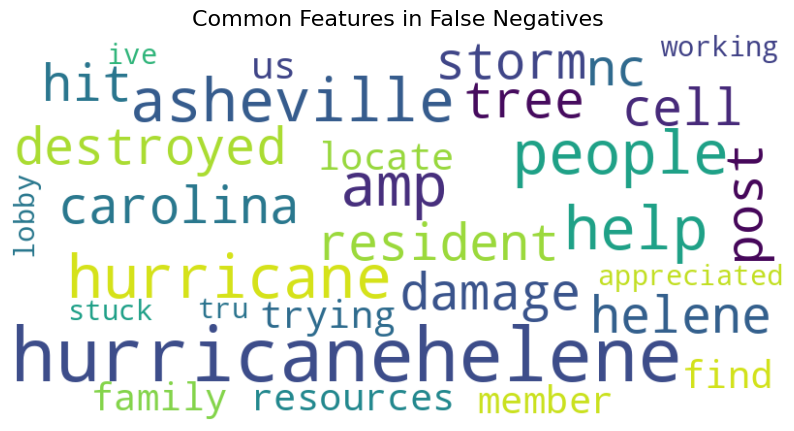

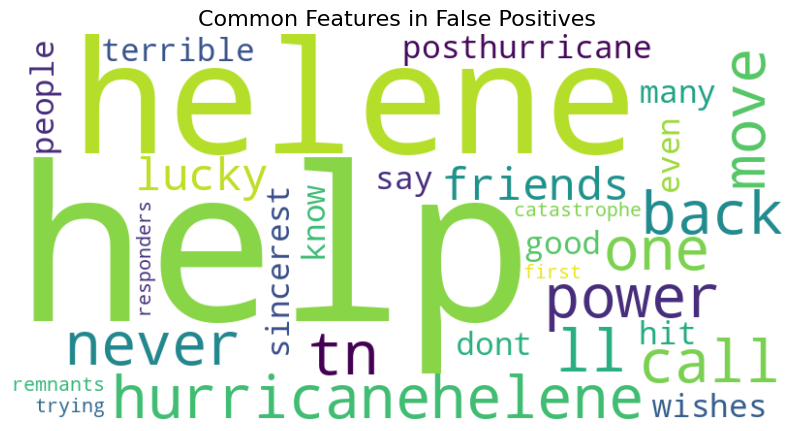

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate and display word clouds
def generate_word_cloud(tweets, title):
    text = " ".join(tweets)
    wordcloud = WordCloud(width=800, height=400, max_words = 30, background_color='white').generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

# False negatives and false positives word cloud
false_negatives_tweets = misclassified_df[misclassified_df['true_label'] == 1]['tweet'].tolist()
false_positives_tweets = misclassified_df[misclassified_df['true_label'] == 0]['tweet'].tolist()

generate_word_cloud(false_negatives_tweets, "Common Features in False Negatives")
generate_word_cloud(false_positives_tweets, "Common Features in False Positives")


<ipython-input-20-d241202489b8>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_counts = full_df.groupby(['length_bin', 'classification']).size().unstack(fill_value=0)


<Figure size 1200x600 with 0 Axes>

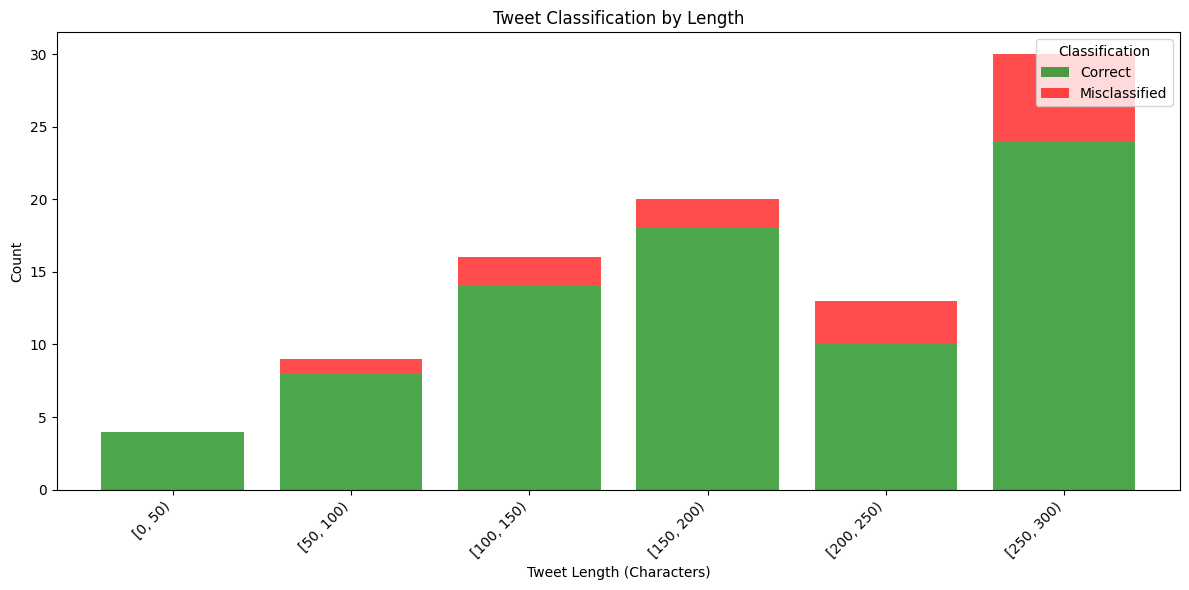

In [ ]:
# Tweet Length Analysis

# Stacked Bar Graph
X_val_lengths = [len(tweet) for tweet in X_val]  # Calculate lengths for all tweets
full_df = pd.DataFrame({
    'tweet': X_val,
    'true_label': y_val,
    'predicted_label': y_val_pred,
    'tweet_length': X_val_lengths
})

full_df['classification'] = np.where(full_df['true_label'] == full_df['predicted_label'], 'Correct', 'Misclassified')

bin_edges = range(0, max(full_df['tweet_length']) + 50, 50)
full_df['length_bin'] = pd.cut(full_df['tweet_length'], bins=bin_edges, right=False)

binned_counts = full_df.groupby(['length_bin', 'classification']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
binned_counts.plot(
    kind='bar',
    stacked=True,
    color=['green', 'red'],
    alpha=0.7,
    width=0.8,
    figsize=(12, 6)
)
plt.title("Tweet Classification by Length")
plt.xlabel("Tweet Length (Characters)")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Classification", loc='upper right')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

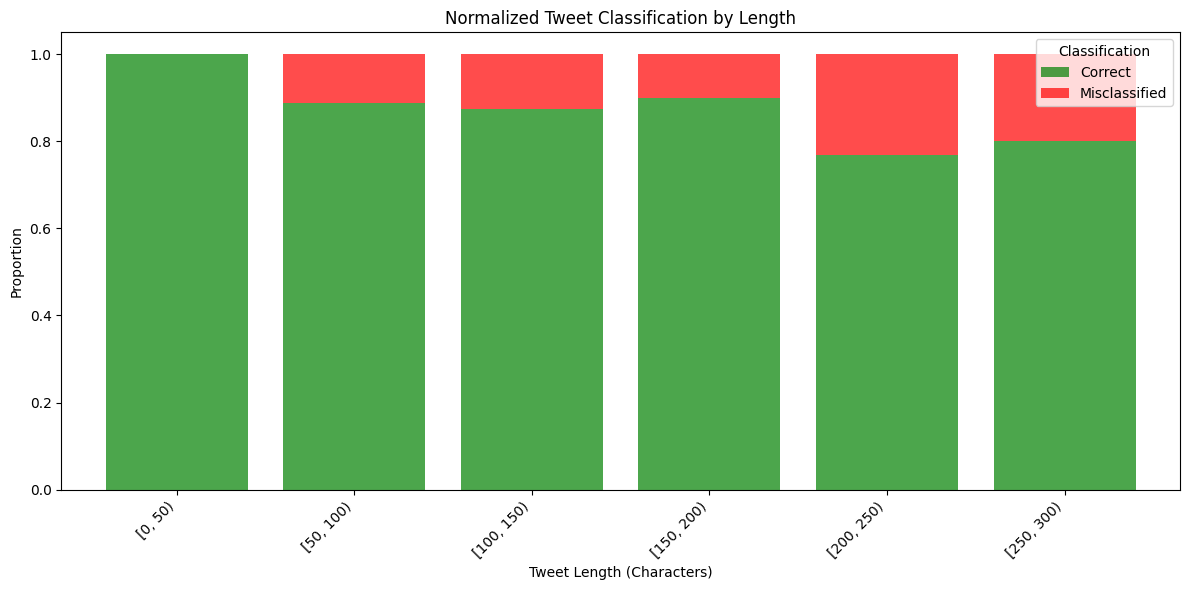

In [ ]:
# Normalize stacked bar graph!
full_df['classification'] = np.where(full_df['true_label'] == full_df['predicted_label'], 'Correct', 'Misclassified')

normalized_counts = binned_counts.div(binned_counts.sum(axis=1), axis=0)

plt.figure(figsize=(12, 6))
normalized_counts.plot(
    kind='bar',
    stacked=True,
    color=['green', 'red'],
    alpha=0.7,
    width=0.8,
    figsize=(12, 6)
)

plt.title("Normalized Tweet Classification by Length")
plt.xlabel("Tweet Length (Characters)")
plt.ylabel("Proportion")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Classification", loc='upper right')
plt.tight_layout()
plt.show()
